In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare stake difference
fig s3 in the manuscript
@author: yuhui
"""
import os
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib
# matplotlib.use('Agg')   # <- force non‐interactive, file‐output backend
import matplotlib.pyplot as plt

import glob
from statsmodels.stats.multitest import multipletests

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# Define stats prefix and coefficient list
stats_prefix = 'stats3.blur1.rbold.'
coef_list = ['ProbMM_valueSH-ProbMM_valueLH', 'ProbMM_valueSH-ProbLMH_valueLH']

# Define ROI list
roi_list = [
    'lc', 'snvta', 'pos_pfc', 'NAc', 'caudate',
    'gray_bridge', 'putamen'
]

In [ ]:
roi_num = len(roi_list)
coef_num = len(coef_list)

# %% Initialize results storage
all_roi_data = []
all_roi_sem = []

all_roi_stakediff_subject = []  # a list of arrays, one array per ROI, each array is per subject

all_roi_subj_ids = []  # To store subject IDs for each ROI

In [ ]:
for roi in roi_list:
    bold_mean_file = f"{stats_prefix}{roi}.1D"
    
    # Define the search pattern
    search_pattern = f"{data_dir}/2*/bold.sft/roiProfile/{bold_mean_file}"

    # Find all matching files
    bold_subj_list = sorted(glob.glob(search_pattern))

    roi_subj_ids = [ os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(f))))
                 for f in bold_subj_list ]
    
    subj_num = len(bold_subj_list)

    if subj_num > 0:
        roi_mean_all = np.zeros((coef_num, subj_num))
        
        for subj_idx, subj_file in enumerate(bold_subj_list):
            temp = np.loadtxt(subj_file)
            if np.sum(np.isnan(temp)) > 0 or np.sum(temp==0) > 0:
                print(f"Warning: Issue detected in {subj_file}")
                print("Loaded Data:")
                print(temp)
                break
            else:
                roi_mean_all[:, subj_idx] = temp
        
        # Convert coef_list to a NumPy array if it's a list
        coef_list = np.array(coef_list)

        # Find indices of required coefficients
        stake_indices = np.where(np.isin(coef_list, ['ProbMM_valueSH-ProbLMH_valueLH']))[0]

        roi_mean_all = np.vstack([
            np.mean(roi_mean_all[stake_indices, :], axis=0),
        ])
        coef_list1 = ['High - Low stake']

        roi_mean = np.mean(roi_mean_all, axis=1)
        roi_sem = np.std(roi_mean_all, axis=1) / np.sqrt(subj_num)

        # Store ROI data for combined plot
        all_roi_data.append(roi_mean)
        all_roi_sem.append(roi_sem)
        all_roi_stakediff_subject.append(roi_mean_all[0, :])

        all_roi_subj_ids.append(roi_subj_ids)

# Convert all ROI data to a NumPy array for plotting
all_roi_data = np.array(all_roi_data)
all_roi_sem = np.array(all_roi_sem)

++ save fig to the server


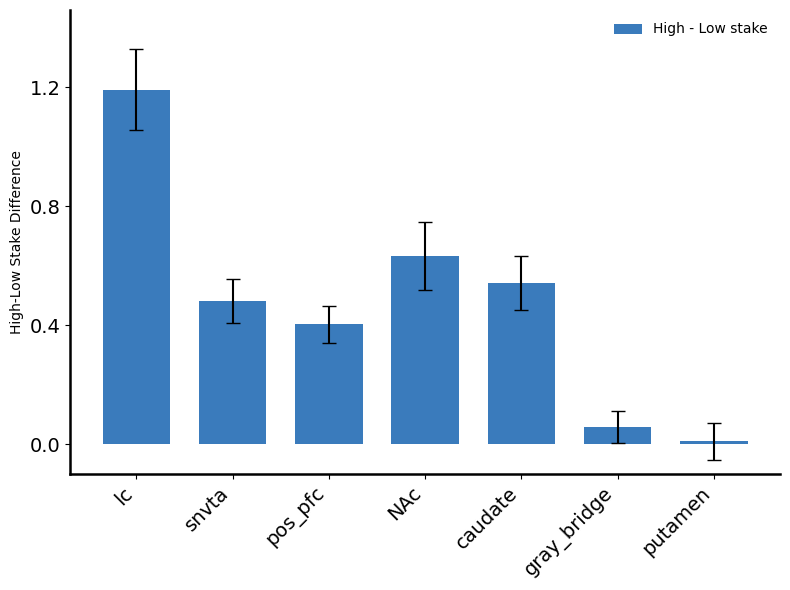

In [ ]:
# %% Combined Bar Plot for All ROIs with Error Bars
fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(roi_list))  # X-axis positions
width = 0.7  # Bar width

# Plot each coefficient as a paired bar with error bars
bars1 = ax.bar(x, all_roi_data[:, 0], width, label=coef_list1[0],
               color='#3a7bbc', yerr=all_roi_sem[:, 0], capsize=5)
# bars2 = ax.bar(x + width/2, all_roi_data[:, 1], width, label=coef_list1[1],
#                color='salmon', yerr=all_roi_sem[:, 1], capsize=5)
# Set Y-axis limit to accommodate text annotations
max_y = np.max(all_roi_data + all_roi_sem)
min_y = np.min(all_roi_data - all_roi_sem)
ax.set_ylim(-0.1, max_y*1.1)

ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("High-Low Stake Difference")
# ax.set_title("Mean Signal Change Across ROIs with Error Bars")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
# Reduce the number of y-ticks using MaxNLocator
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(5))  # Limits to 5 ticks on y-axis
ax.legend()
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)  
ax.spines['bottom'].set_linewidth(1.8)
# # ax.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

plt.tight_layout()
plt.savefig("output/roi_stakedif.png", dpi=300, bbox_inches='tight')
print("++ save fig to the server")

In [ ]:
from statsmodels.stats.multitest import multipletests

lc_index = roi_list.index('lc')
lc_stakediff = all_roi_stakediff_subject[lc_index]

comparison_stakediff = []
raw_pvals = []  # to collect raw p-values for correction

for i, roi in enumerate(roi_list):
    if roi == 'lc':
        continue

    other_stakediff = all_roi_stakediff_subject[i]

    t_stat, p_val = stats.ttest_rel(lc_stakediff, other_stakediff)
    df = len(lc_stakediff) - 1
    test_type = 'paired'
    diff = lc_stakediff - other_stakediff
    cohen_d = np.mean(diff) / np.std(diff, ddof=1)

    raw_pvals.append(p_val)

    comparison_stakediff.append([
        roi,
        t_stat,
        p_val,
        cohen_d,
        f"t({df})"
    ])

# Apply FDR correction
_, corrected_pvals, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')

# Add corrected p-values to the results
for row, p_corr in zip(comparison_stakediff, corrected_pvals):
    row.append(p_corr)

# Create DataFrame
df_lc_stakediff = pd.DataFrame(
    comparison_stakediff,
    columns=['ROI', 't_value', 'p_value', 'cohen_d', 't(df)', 'p_value_corrected']
)

print("LC_ROI stakediff vs others (with FDR correction):")
print(df_lc_stakediff)

LC_ROI stakediff vs others (with FDR correction):
           ROI   t_value       p_value   cohen_d  t(df)  p_value_corrected
0        snvta  4.309502  3.781039e-04  0.963634  t(19)           0.000567
1      pos_pfc  4.946415  8.961578e-05  1.106052  t(19)           0.000179
2          NAc  3.155021  5.213678e-03  0.705484  t(19)           0.005214
3      caudate  3.671428  1.621994e-03  0.820956  t(19)           0.001946
4  gray_bridge  7.198574  7.746128e-07  1.609650  t(19)           0.000002
5      putamen  7.817602  2.356619e-07  1.748069  t(19)           0.000001


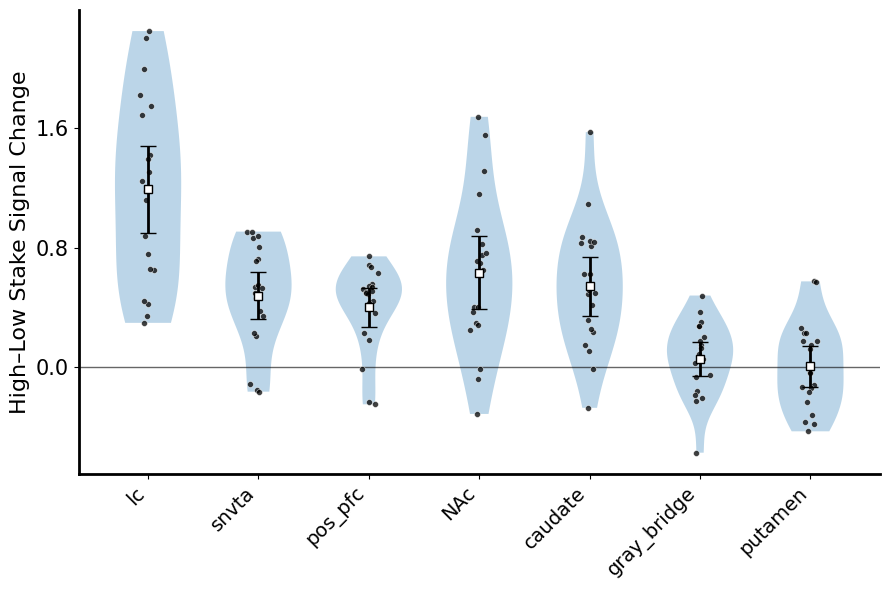

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_1samp, t

# === settings ===
CI_LEVEL  = 0.95       # set to 0.90 if you prefer 90% CI
JITTER_SD = 0.04
rng = np.random.default_rng(7)  # reproducible jitter

# Expect: roi_list (list of str), all_roi_stakediff_subject (list of 1D arrays), same order/length.
x = np.arange(len(roi_list))

# ---- compute stats IN ORIGINAL ORDER ----
rows, p_list, t_list = [], [], []
for roi, vals in zip(roi_list, all_roi_stakediff_subject):
    v = np.asarray(vals, float)
    v = v[~np.isnan(v)]
    n  = v.size
    m  = np.nanmean(v)
    sd = np.nanstd(v, ddof=1)
    se = sd/np.sqrt(n) if n > 0 else np.nan
    crit = t.ppf(0.5 + CI_LEVEL/2.0, n-1) if n > 1 else np.nan
    ci  = crit*se if n > 1 else np.nan
    tstat, p = ttest_1samp(v, 0.0, nan_policy='omit') if n > 1 else (np.nan, np.nan)
    p_list.append(p); t_list.append(tstat)
    rows.append(dict(ROI=roi, n=n, mean=m, sd=sd, se=se,
                     ci_lo=(m-ci) if np.isfinite(ci) else np.nan,
                     ci_hi=(m+ci) if np.isfinite(ci) else np.nan,
                     t=tstat, p=p))

df_stats = pd.DataFrame(rows)  # order matches roi_list

# ---- plot (original ROI order) ----
fig, ax = plt.subplots(figsize=(9, 6))

parts = ax.violinplot(all_roi_stakediff_subject,
                      positions=x, widths=0.6,
                      showmeans=False, showmedians=False, showextrema=False)
for b in parts['bodies']:
    b.set_alpha(0.30)
    b.set_edgecolor('none')

# points + median
for xi, vals in zip(x, all_roi_stakediff_subject):
    v = np.asarray(vals, float)
    v = v[~np.isnan(v)]
    jitter = rng.normal(0, JITTER_SD, size=v.size)
    ax.scatter(np.full(v.size, xi) + jitter, v, s=18, alpha=0.75,
               color='k', zorder=5, linewidth=0.4, edgecolor='white')

# mean ± CI (same order)
for xi, r in zip(x, rows):
    if np.isfinite(r["ci_lo"]) and np.isfinite(r["ci_hi"]):
        yerr = [[r["mean"] - r["ci_lo"]], [r["ci_hi"] - r["mean"]]]
    else:
        yerr = None
    ax.errorbar(xi, r["mean"], yerr=yerr, fmt='s',
                mfc='white', mec='k', ecolor='k',
                capsize=6, zorder=7, elinewidth=2)

# cosmetics
ax.axhline(0, color='k', lw=1, alpha=0.6)
ax.set_xticks(x); ax.set_xticklabels(roi_list, rotation=45, ha='right', fontsize=15)
ax.set_ylabel("High–Low Stake Signal Change", fontsize=16)
ax.tick_params(axis='y', labelsize=15); ax.tick_params(axis='x', labelsize=14)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2); ax.spines['bottom'].set_linewidth(2)
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.tight_layout()
plt.savefig("output/roi_stakediff_violin_sup.png", dpi=350, bbox_inches='tight')